In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [141]:
df = pd.read_csv("./train.csv").drop('id',axis=1)
test = pd.read_csv("./test.csv")
print(df.columns)
print(df['defects'][0])

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')
False


In [142]:
neg, pos = np.bincount(df['defects'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

initial_bias = np.log([pos/neg])
initial_bias = output_bias = tf.keras.initializers.Constant(initial_bias)

Examples:
    Total: 101763
    Positive: 23064 (22.66% of total)



In [143]:
eps = 0.01
df['e'] = np.log(df.pop('e')+eps)


X = df.drop(['defects'],axis=1)
y = df['defects']

X = StandardScaler().fit_transform(X)

# x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.99, random_state=42)

In [148]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu',input_shape=(21,)),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid',bias_initializer=initial_bias)
])

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

history = model.fit(X,y,epochs=5,batch_size=5)

Epoch 1/5
20353/20353 [==============================] - 38s 2ms/step - loss: 0.4475 - tp: 6478.0000 - fp: 3459.0000 - tn: 75240.0000 - fn: 16586.0000 - accuracy: 0.8030 - precision: 0.6519 - recall: 0.2809 - auc: 0.7741 - prc: 0.5277
Epoch 2/5
20353/20353 [==============================] - 34s 2ms/step - loss: 0.4403 - tp: 7504.0000 - fp: 3940.0000 - tn: 74759.0000 - fn: 15560.0000 - accuracy: 0.8084 - precision: 0.6557 - recall: 0.3254 - auc: 0.7794 - prc: 0.5417
Epoch 3/5
20353/20353 [==============================] - 36s 2ms/step - loss: 0.4395 - tp: 7673.0000 - fp: 4057.0000 - tn: 74642.0000 - fn: 15391.0000 - accuracy: 0.8089 - precision: 0.6541 - recall: 0.3327 - auc: 0.7806 - prc: 0.5420
Epoch 4/5
20353/20353 [==============================] - 38s 2ms/step - loss: 0.4384 - tp: 7874.0000 - fp: 4139.0000 - tn: 74560.0000 - fn: 15190.0000 - accuracy: 0.8101 - precision: 0.6555 - recall: 0.3414 - auc: 0.7816 - prc: 0.5434
Epoch 5/5
20353/20353 [==============================] - 35s

In [149]:
def plot_loss(history):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color='blue')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')

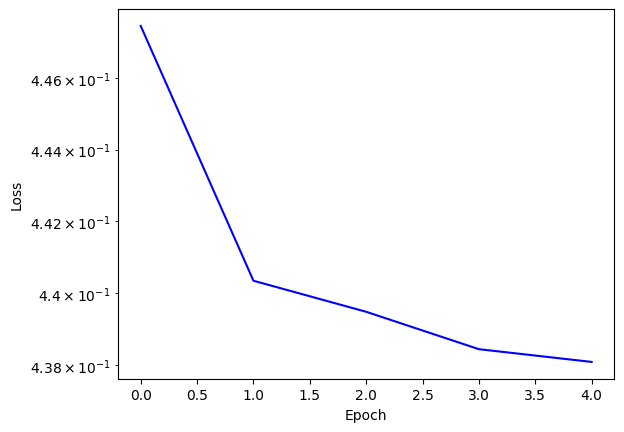

In [150]:
plot_loss(history)

In [123]:
test_X = test
test_X = StandardScaler().fit_transform(test_X)

# index = 3
# y_pred = model(np.array([x_train[index]]))
# print(y_pred)
# print(y_train[index])

y_pred = model.predict(test_X)

y_pred = StandardScaler().fit_transform(y_pred)
print(y_pred)
submission = pd.DataFrame()

submission['id'] = np.arange(101763,101763 + len(y_pred[:67842]))
submission['defects'] = y_pred[:67842]

# print(submission)
# submission.to_csv("./submission.csv",index=False)

3181/3181 [==============================] - 4s 1ms/step
[[-0.770957  ]
 [-0.9686515 ]
 [-1.0951163 ]
 ...
 [-0.31783655]
 [-1.0481597 ]
 [ 1.8051608 ]]


In [124]:
submission.set_index('id',inplace=True)
submission['defects'] = submission['defects'].add(1)
submission.clip(0,1,inplace=True)

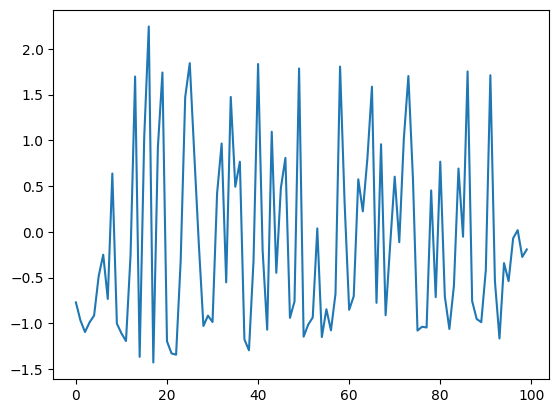

In [125]:
plt.plot(np.arange(100),y_pred[:100])

In [128]:
submission.to_csv('submissionDeep.csv')